# A neural network in Python from scratch

In [29]:
import numpy as np
from typing import Union, Callable
from copy import deepcopy
from optim_utilities import print_rec

from forward_propagation import (
    forward_propagation, 
    create_weights, 
    vector_to_weights)

from activation_functions import relu, sigmoid 
from test_functions import (
    linear_function,
    ackley,
    sphere,
    quadratic,
    rosen,
    L1norm,
    sphereL1
)

from gradient_descent import gradient_descent

%load_ext autoreload
%autoreload 2
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Multiple inputs

Give as inputs a vector $(1,2,5,4)$, processed by a layer of 3 neurons.  
`weights` has dimension $\text{nb_inputs}\times (\text{nb_neurons}+1)$   (the +1 is for the biases, the last column of `weights`, -1, 0 and 1 in the first example).

In [2]:
inputs = np.array([[1,2,5,4]])
weights = [
        np.array(
            [
                [1,0.2,0.5,1,-1],
                [2,1,3,5,0],
                [0.2,0.1,0.6,0.78,1]
            ]
        )
    ]
activation = sigmoid
forward_propagation(inputs,weights,activation)

array([[0.99899323, 1.        , 0.99945816]])

Another example:

In [3]:
inputs = np.array([[1,0.2,0.15,0.024]])
weights = [
        np.array(
            [
                [1,0.2,0.5,1,-1],
                [2,1,3,5,0],
                [0.2,0.1,0.6,0.78,1]
            ]
        )
    ]
activation = sigmoid
forward_propagation(inputs,weights,activation)

array([[0.53469416, 0.94103299, 0.79062883]])

With the same network, calculate 2 data inputs entered as rows in `inputs`:

In [4]:
inputs = np.array([[1,2,5,4],[1,0.2,0.15,0.024]])
weights = [
        np.array(
            [
                [1,0.2,0.5,1,-1],
                [2,1,3,5,0],
                [0.2,0.1,0.6,0.78,1]
            ]
        )
    ]
activation = sigmoid
forward_propagation(inputs,weights,activation)

array([[0.99899323, 1.        , 0.99945816],
       [0.53469416, 0.94103299, 0.79062883]])

The following network has 2 layers, the first going from the 4 input components to the 3 internal neurons, the second going from the 3 internal neurons outputs to the 2 outputs:

In [5]:
inputs = np.array([[1,2,5,4],[1,0.2,0.15,0.024]])
weights = [
        np.array(
            [
                [1,0.2,0.5,1,-1],
                [2,1,3,5,0],
                [0.2,0.1,0.6,0.78,1]
            ]
        ),
    np.array(
            [
                [1,0.2,0.5,1],
                [2,1,3,5]
            ]
        )
    ]
activation = sigmoid
forward_propagation(inputs,weights,activation)

array([[0.93695121, 0.99998324],
       [0.89266103, 0.99991581]])

### Create a data set 
The data set is made of points sampled randomly from a function.

In [7]:
def simulate_data_target(fun: Callable,
                       n_features: int,
                       n_obs: int,
                       LB: list[float],
                       UB: list[float]) -> dict:
    
    entry_data = np.random.uniform(low= LB,high=UB,
                                   size=(n_obs, n_features))
    target = np.apply_along_axis(fun, 1, entry_data)
    
    return {"data": entry_data, "target": target}

In [8]:
#used_function = test_functions.sphere
used_function = linear_function
n_features = 2
LB = [-5] * n_features
UB = [5] * n_features
simulated_data = simulate_data_target(fun = used_function,n_features = 2,n_obs=10,LB=LB,UB=UB)

In [9]:
simulated_data

{'data': array([[-1.25459881,  4.50714306],
        [ 2.31993942,  0.98658484],
        [-3.4398136 , -3.4400548 ],
        [-4.41916388,  3.66176146],
        [ 1.01115012,  2.08072578],
        [-4.79415506,  4.69909852],
        [ 3.32442641, -2.87660889],
        [-3.18175033, -3.1659549 ],
        [-1.95757757,  0.24756432],
        [-0.68054981, -2.0877086 ]]),
 'target': array([10.75968732,  7.2931091 , -7.31992319,  5.90435904,  8.17260167,
         7.60404199,  0.57120862, -6.51366013,  1.53755106, -1.85596701])}

### Neural Network weight and output

Create a NN with 1 layer, 2 inputs and 1 output

In [14]:
weights = create_weights([2,1])
predicted_output = forward_propagation(simulated_data["data"],weights,sigmoid)

In [15]:
weights

[array([[ 0.28677805, -0.07982693,  0.37394315]])]

In [17]:
simulated_data["target"]

array([10.75968732,  7.2931091 , -7.31992319,  5.90435904,  8.17260167,
        7.60404199,  0.57120862, -6.51366013,  1.53755106, -1.85596701])

In [18]:
predicted_output.reshape(-1,)

array([0.41444019, 0.72322086, 0.41631704, 0.23403188, 0.62194709,
       0.20164737, 0.82591476, 0.42903619, 0.4483822 , 0.58550936])

In [19]:
vector_to_weights([0.28677805, -0.07982693,  0.37394315],[2,1])

[array([[ 0.28677805, -0.07982693,  0.37394315]])]

### Error function

In [20]:
# mean squared error
def cost_function_mse(y_predicted: np.ndarray,y_observed: np.ndarray):
    error = 0.5 * np.mean((y_predicted - y_observed)**2)
    return error

In [21]:
# entropy
def cost_function_entropy(y_predicted: np.ndarray,y_observed: np.ndarray):

    n = len(y_observed)
    
    term_A = np.multiply(np.log(y_predicted),y_observed)
    term_B = np.multiply(1-y_observed,np.log(1-y_predicted))
    
    error = - (1/n)*(np.sum(term_A)+np.sum(term_B))

    return(error)

In [22]:
def error_with_parameters(vector_weights: np.ndarray,
                          activation_function: Callable,
                          data: dict,
                          cost_function: Callable,
                          regularization: float = 0) -> float:
    
    weights = vector_to_weights(vector_weights,used_network_structure)
    predicted_output = forward_propagation(data["data"],weights,activation_function)
    predicted_output = predicted_output.reshape(-1,)
    
    error = cost_function(predicted_output,data["target"]) + regularization * np.sum(np.abs(vector_weights))
    
    return error

In [25]:
used_network_structure = [2,1] # 2 inputs features, 1 layer with 1 node
used_activation = relu
used_data = simulated_data
used_cost_function = cost_function_mse

def neural_network_cost(vector_weights):
    
    cost = error_with_parameters(vector_weights,
                          activation_function = used_activation,
                          data = used_data,
                          cost_function = used_cost_function)
    
    return cost

In [26]:
neural_network_cost(np.array([0.28677805, -0.07982693,  0.37394315]))

20.582449424182073

### Gradient descent

In [30]:
LB = [-5] * 3 
UB = [5] * 3
printlevel = 1
res = gradient_descent(func = neural_network_cost,
                 start_x = np.array([0.28677805, -0.07982693,  0.37394315]),
                 LB = LB, UB = UB,budget = 1000,printlevel=printlevel)

search stopped after 1011 evaluations of f because of budget exhausted 
best objective function = 4.972682866697983
best x = [1.00000322 2.00000681 2.99997684]


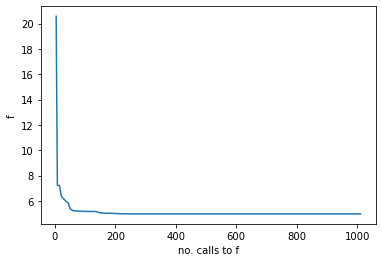

In [31]:
print_rec(res=res, fun=neural_network_cost, dim=len(res["x_best"]), LB=LB, UB=UB , printlevel=printlevel, logscale = False)